In [1]:
import torch
import numpy as np

from lafomo.datasets import ToySpatialTranscriptomics
from lafomo.options import VariationalOptions
from lafomo.utilities.torch import save, load
from lafomo.plot import Plotter

from matplotlib import pyplot as plt

from fenics import *
from fenics_adjoint import *

import torch_fenics

In [30]:
import pandas as pd
data = pd.read_csv('../data/demToy1GPGene.csv')
data = pd.read_csv('../data/demToy1GPmRNA.csv')
display(data.head(5))

vals = data.values

def plot_output(ax, output, title=None):
    ax.set_title(title)
    ax.plot(output)
    ax.set_xlabel('distance')
    ax.set_ylabel('y')
def scatter_output(ax, output, title=None):
    ax.set_title(title)
    ax.scatter(data.iloc[:, 0], data.iloc[:, 1], c=output)
    ax.set_xlabel('time')
    ax.set_ylabel('distance')
    ax.set_aspect('equal')

,t,x,U,Y
0,0.000,0.0,0.978006,0.0
1,0.025,0.0,1.009034,0.0
2,0.050,0.0,1.006165,0.0
3,0.075,0.0,0.967695,0.0
4,0.100,0.0,0.893023,0.0


In [3]:
## REACTION DIFFUSION FENICS MODULE
class ReactionDiffusion(torch_fenics.FEniCSModule):
    # Construct variables which can be in the constructor
    def __init__(self, mesh_cells):
        super().__init__()

        # Create function space
        mesh = UnitIntervalMesh(mesh_cells)
        self.V = FunctionSpace(mesh, 'P', 1)

        # Create trial and test functions
        y = TrialFunction(self.V)
        self.v = TestFunction(self.V)


    def solve(self, y_prev, u, sensitivity, decay, diffusion):
        # Construct bilinear form (Arity = 2 (for both Trial and Test function))
        y = TrialFunction(self.V)
        self.a = (1 + dt * decay) * y * self.v * dx +\
         dt * diffusion * inner(grad(y), grad(self.v)) * dx

        # Construct linear form
        L = (y_prev + dt * sensitivity * u) * self.v * dx

        # Construct boundary condition
        bc = DirichletBC(self.V, Constant(0), 'on_boundary')

        # Solve the Poisson equation
        y = Function(self.V)
        solve(self.a == L, y, bc)

        return y

    def input_templates(self):
        # Declare templates for the inputs to Poisson.solve
        return Function(self.V), Function(self.V), \
               Constant(0), Constant(0), Constant(0)

In [54]:
from torch.nn import Parameter
from lafomo.datasets import LFMDataset
from lafomo import LFM
from lafomo.variational.models import OrdinaryLFM

T = 1.0            # final time
num_steps = 40     # number of time steps
dt = T / num_steps # time step size

class PartialLFM(OrdinaryLFM):
    def __init__(self, num_outputs, num_latents, t_inducing,
                 dataset: LFMDataset, options: VariationalOptions, dtype=torch.float64):
        super().__init__(num_outputs, num_latents, t_inducing, dataset, options, dtype)
        if self.options.initial_conditions:
            raise Exception('Initial conditions are not implemented for PartialLFM.')

        self.mesh_cells = 40
        self.fenics_module = ReactionDiffusion(self.mesh_cells)
        self.sensitivity = Parameter(torch.ones((1, 1), dtype=torch.float64), requires_grad=True)
        self.decay = Parameter(0.1*torch.ones((1, 1), dtype=torch.float64), requires_grad=True)
        self.diffusion = Parameter(0.01*torch.ones((1, 1), dtype=torch.float64), requires_grad=True)

    def forward(self, t, h, compute_var=False, return_samples=False):
        """
        t : torch.Tensor
            Shape (num_times)
        h : torch.Tensor the initial state of the ODE
            Shape (num_genes, 1)
        Returns
        -------
        Returns evolved h across times t.
        Shape (num_genes, num_points).
        """
        self.nfe = 0

        # Precompute variables
        self.Kmm = self.kernel(self.inducing_inputs)
        self.L = torch.cholesky(self.Kmm)
        q_cholS = torch.tril(self.q_cholS)
        self.S = torch.matmul(q_cholS, torch.transpose(q_cholS, 1, 2))

        # Integrate forward from the initial positions h0.
        h0 = self.initial_state(h)

        ####
        outputs = list()
        y_prev = torch.zeros((1, self.mesh_cells + 1), requires_grad=False, dtype=torch.float64)
        t_index = 0

        for n in range(num_steps+1):
            u = data[data['t'] == t[t_index]]['U'].values
            u = torch.tensor(u, requires_grad=False).unsqueeze(0)
            print(u.shape)
            u = self.get_latents(t[t_index])
            print(u.shape)
            y_prev = self.fenics_module(y_prev, u,
                                        self.sensitivity, self.decay, self.diffusion)

            # y_prev shape (N, 21)
            t_index += 1
            outputs.append(y_prev)
        outputs = torch.stack(outputs).permute(1, 0, 2)  # shape (batch, times, distance)

        return outputs
        ####
        # h_samples = odeint(self.odefunc, h0, t, )  # (T, S, num_outputs, 1)
        #
        # if return_samples:
        #     return h_samples
        #
        # h_out = torch.mean(h_samples, dim=1).transpose(0, 1)
        # h_std = torch.std(h_samples, dim=1).transpose(0, 1)
        #
        # if compute_var:
        #     return self.decode(h_out), h_std
        # return self.decode(h_out)


In [55]:
from lafomo.variational.trainer import Trainer

class PDETrainer(Trainer):

    def single_epoch(self, *args):
        epoch_loss = 0
        epoch_ll = 0
        epoch_kl = 0
        output = None
        # for i, data in enumerate(self.data_loader):

        self.optimizer.zero_grad()
        # t, y = data
        # t = t.cuda() if is_cuda() else t
        # y = y.cuda() if is_cuda() else y
        # # Assume that the batch of t s are the same
        # t, y = t[0].view(-1), y
        # initial_value = self.initial_value(y)
        initial_value = None
        t = data['t'].values

        output = self.model(t, initial_value)

        y_target = torch.tensor(data['Y'].values).unsqueeze(0)
        print(y_target.shape)
        print(output.shape)
        output = output.transpose(1, 2).reshape(-1)
        print(output.shape)
        # loss = self.loss_fn(y_prev, y_target)
        # loss.backward()
        fig, axes = plt.subplots(ncols=2)
        scatter_output(axes[0], output.detach(), 'Prediction')
        scatter_output(axes[1], data.iloc[:, 3], 'Actual')

        # Calc loss and backprop gradients
        mult = 1
        if self.num_epochs <= 10:
            mult = self.num_epochs/10

        ll, kl = self.model.elbo(y_target, output, mult)
        total_loss = -ll #+ kl

        total_loss.backward()
        print('ses', self.model.sensitivity)
        print('grad', self.model.sensitivity.grad)

        self.optimizer.step()
        print("ses", self.model.sensitivity)

        epoch_loss += total_loss.item()
        epoch_ll += ll.item()
        epoch_kl += kl.item()

        # end for
        return output, epoch_loss, (-epoch_ll, epoch_kl)


options = VariationalOptions(initial_conditions=False)

dataset = ToySpatialTranscriptomics()
model = PartialLFM(1, 1, torch.ones(10), dataset, options)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
trainer = PDETrainer(model, optimizer, dataset)

/Users/jacob/Documents/proj/reggae/lafomo/variational/models/model.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inducing_inputs = Parameter(torch.tensor(t_inducing), requires_grad=options.learn_inducing)


In [56]:
trainer.train(2)

torch.Size([1, 41])


TypeError: Cannot interpret '-1' as a data type

NameError: name 'us' is not defined

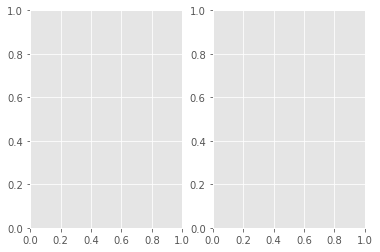

In [14]:
fig, axes = plt.subplots(ncols=2)
scatter_output(axes[0], us.transpose(1, 2).reshape(-1), 'Prediction')
scatter_output(axes[1], data.iloc[:, 3], 'Actual')

plt.tight_layout()
fig, axes = plt.subplots(ncols=2)
plot_output(axes[0], us[0, 4, :], 'Prediction')
plot_output(axes[1], data[data['t'] == ts[4]].iloc[:, 3], 'Actual')

Text(0, 0.5, 'u')

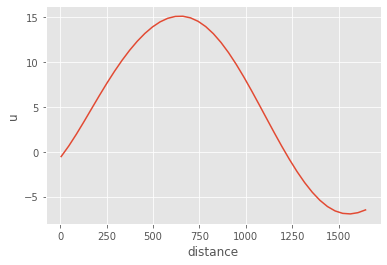

In [94]:
plt.plot(data[data['t'] == ts[5]].iloc[:, 2])
plt.xlabel('distance')
plt.ylabel('u')

